In [2]:
!pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
pyro.set_rng_seed(42)



1. Dataset Preparation



In [4]:
# Generate synthetic data for demonstration
def generate_data(num_samples=10000, num_features=20):
    X = np.random.randn(num_samples, num_features)
    weights = np.random.randn(num_features)
    logits = X @ weights + np.random.randn(num_samples) * 0.1
    y = (logits > 0).astype(int)
    return X, y

X, y = generate_data()

# Split into target and shadow datasets (for membership inference)
X_target, X_shadow, y_target, y_shadow = train_test_split(X, y, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
X_target = torch.FloatTensor(X_target).to(device)
y_target = torch.FloatTensor(y_target).to(device)
X_shadow = torch.FloatTensor(X_shadow).to(device)
y_shadow = torch.FloatTensor(y_shadow).to(device)

# Create datasets
target_dataset = TensorDataset(X_target, y_target)
shadow_dataset = TensorDataset(X_shadow, y_shadow)

# Split shadow dataset into train and test for membership inference
shadow_train, shadow_test = random_split(shadow_dataset, [0.7, 0.3])

2. Model Definition


In [5]:
class SimpleModel(nn.Module):
    def __init__(self, input_dim):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

3. Differential Privacy Utilities



In [6]:
def dp_sgd_step(model, optimizer, x, y, sigma, max_grad_norm):

    optimizer.zero_grad()
    output = model(x)
    loss = nn.BCELoss()(output.squeeze(), y)
    loss.backward()

    # Clip gradients and add noise for DP
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5

    # Clip gradients
    clip_coef = max_grad_norm / (total_norm + 1e-6)
    if clip_coef < 1:
        for p in model.parameters():
            if p.grad is not None:
                p.grad.data.mul_(clip_coef)

    # Add Gaussian noise
    for p in model.parameters():
        if p.grad is not None:
            noise = torch.randn_like(p.grad) * sigma * max_grad_norm
            p.grad.data.add_(noise)

    optimizer.step()
    return loss.item()

4. Membership Inference Attack

Following the paper, we'll implement a membership inference attack to estimate privacy.

In [24]:
class AttackModel(nn.Module):
    """Model to predict membership based on model outputs"""
    def __init__(self, input_dim=3):
        super(AttackModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

def train_attack_model(target_model, shadow_train, shadow_test, device):

    # Prepare data for attack model
    attack_X = []
    attack_y = []

    # We'll use 5 shadow models as in the paper
    num_shadow_models = 5

    for i in range(num_shadow_models):
        # Split shadow data into in and out samples
        shadow_in, shadow_out = random_split(shadow_train, [0.5, 0.5])

        # Train model on in samples
        model = SimpleModel(shadow_train[0][0].shape[0]).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Create dataloaders
        in_loader = DataLoader(shadow_in, batch_size=32, shuffle=True)

        # Train for a few epochs
        for epoch in range(5):
            for x, y in in_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                output = model(x)
                loss = nn.BCELoss()(output.squeeze(), y)
                loss.backward()
                optimizer.step()

        # Evaluate on both in and out samples to get features
        with torch.no_grad():
            # In samples
            x_in, y_in = shadow_in[:]
            pred_in = model(x_in.to(device))
            loss_in = nn.BCELoss(reduction='none')(pred_in.squeeze(), y_in.to(device))

            # Create features: prediction, loss, correctness
            features_in = torch.stack([
                pred_in.squeeze(),
                loss_in,
                (pred_in.squeeze().round() == y_in.to(device)).float()
            ], dim=1)

            attack_X.append(features_in)
            attack_y.append(torch.ones(len(shadow_in)))

            # Out samples
            x_out, y_out = shadow_out[:]
            pred_out = model(x_out.to(device))
            loss_out = nn.BCELoss(reduction='none')(pred_out.squeeze(), y_out.to(device))

            features_out = torch.stack([
                pred_out.squeeze(),
                loss_out,
                (pred_out.squeeze().round() == y_out.to(device)).float()
            ], dim=1)

            attack_X.append(features_out)
            attack_y.append(torch.zeros(len(shadow_out)))

    # Concatenate all features
    attack_X = torch.cat(attack_X, dim=0)
    attack_y = torch.cat(attack_y, dim=0)

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        attack_X.cpu().numpy(),
        attack_y.cpu().numpy(),
        test_size=0.2,
        random_state=42
    )

    # Train attack model
    attack_model = AttackModel(input_dim=3).to(device)
    optimizer = optim.Adam(attack_model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # Convert to torch tensors
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).to(device)
    X_test = torch.FloatTensor(X_test).to(device)
    y_test = torch.FloatTensor(y_test).to(device)

    # Train
    for epoch in range(10):
        optimizer.zero_grad()
        outputs = attack_model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

    # Evaluate
    with torch.no_grad():
        outputs = attack_model(X_test)
        preds = outputs.round().squeeze()
        accuracy = (preds == y_test).float().mean()
        auc = roc_auc_score(y_test.cpu().numpy(), outputs.squeeze().cpu().numpy())

    print(f"Attack model accuracy: {accuracy.item():.4f}, AUC: {auc:.4f}")

    return attack_model, accuracy.item()

5. Bayesian Privacy Estimation

Now we'll implement the core Bayesian estimation framework from the paper.

In [28]:
def bayesian_privacy_estimation(attack_results, num_samples=1000):

    # Unpack attack results
    tpr = attack_results['tpr']
    fpr = attack_results['fpr']
    n_members = attack_results['n_members']
    n_non_members = attack_results['n_non_members']

    # Handle edge cases where TPR or FPR is 0
    if tpr == 0 or fpr == 0:
        tpr = max(tpr, 1e-3)
        fpr = max(fpr, 1e-3)

    def model(tpr_obs, fpr_obs):
        # Priors for true positive rate (tpr) and false positive rate (fpr)
        alpha_tpr = 1.0
        beta_tpr = 1.0
        alpha_fpr = 1.0
        beta_fpr = 1.0

        # Sample from Beta priors
        tpr_true = pyro.sample("tpr_true", dist.Beta(alpha_tpr, beta_tpr))
        fpr_true = pyro.sample("fpr_true", dist.Beta(alpha_fpr, beta_fpr))

        # Likelihood (binomial)
        pyro.sample("tpr_obs", dist.Binomial(n_members, tpr_true), obs=tpr_obs)
        pyro.sample("fpr_obs", dist.Binomial(n_non_members, fpr_true), obs=fpr_obs)

        # Compute privacy parameters
        epsilon = pyro.deterministic("epsilon", torch.log((tpr_true / fpr_true).clamp(min=1e-10)))
        delta = pyro.deterministic("delta", (tpr_true - torch.exp(epsilon) * fpr_true).clamp(min=0.0, max=1.0))

        return {"epsilon": epsilon, "delta": delta}

    # Convert observations to tensors
    tpr_obs = torch.tensor(tpr * n_members, dtype=torch.float32)
    fpr_obs = torch.tensor(fpr * n_non_members, dtype=torch.float32)

    # Run MCMC
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel,
               num_samples=num_samples,
               warmup_steps=200,
               num_chains=1)

    mcmc.run(tpr_obs, fpr_obs)

    # Get samples - convert to numpy arrays immediately
    samples = mcmc.get_samples(group_by_chain=False)

    # Compute epsilon and delta from the samples
    tpr_samples = samples["tpr_true"].cpu().numpy()
    fpr_samples = samples["fpr_true"].cpu().numpy()

    epsilon_samples = np.log(np.clip(tpr_samples / fpr_samples, 1e-10, None))
    delta_samples = np.clip(tpr_samples - np.exp(epsilon_samples) * fpr_samples, 0.0, 1.0)

    return {
        "epsilon": epsilon_samples,
        "delta": delta_samples,
        "tpr": tpr_samples,
        "fpr": fpr_samples
    }

6. Full Pipeline Implementation

In [29]:
def run_full_pipeline(X, y, dp_params=None, num_trials=10):

    if dp_params is None:
        dp_params = {'sigma': 1.0, 'max_grad_norm': 1.0}

    # Split into target and shadow datasets
    X_target, X_shadow, y_target, y_shadow = train_test_split(X, y, test_size=0.5, random_state=42)

    # Convert to PyTorch tensors
    X_target = torch.FloatTensor(X_target).to(device)
    y_target = torch.FloatTensor(y_target).to(device)
    X_shadow = torch.FloatTensor(X_shadow).to(device)
    y_shadow = torch.FloatTensor(y_shadow).to(device)

    # Create datasets
    target_dataset = TensorDataset(X_target, y_target)
    shadow_dataset = TensorDataset(X_shadow, y_shadow)

    # Split shadow dataset into train and test for membership inference
    shadow_train, shadow_test = random_split(shadow_dataset, [0.7, 0.3])

    # Train attack model using shadow models
    input_dim = X_target.shape[1]
    target_model = SimpleModel(input_dim).to(device)
    attack_model, attack_accuracy = train_attack_model(target_model, shadow_train, shadow_test, device)

    # evaluate on target model with DP
    print("\nTraining target model with DP...")
    target_model = SimpleModel(input_dim).to(device)
    optimizer = optim.Adam(target_model.parameters(), lr=0.001)

    # Create dataloader
    target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True)

    # Train with DP-SGD
    for epoch in range(5):
        for x, y in target_loader:
            x, y = x.to(device), y.to(device)
            loss = dp_sgd_step(target_model, optimizer, x, y,
                             dp_params['sigma'], dp_params['max_grad_norm'])
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

    # Perform membership inference attack
    print("\nPerforming membership inference attack...")

    # Split target data into members and non-members for evaluation
    target_members, target_non_members = random_split(target_dataset, [0.5, 0.5])

    # Get predictions and features for attack model
    with torch.no_grad():
        # Members
        x_mem, y_mem = target_members[:]
        pred_mem = target_model(x_mem.to(device))
        loss_mem = nn.BCELoss(reduction='none')(pred_mem.squeeze(), y_mem.to(device))

        mem_features = torch.stack([
            pred_mem.squeeze(),
            loss_mem,
            (pred_mem.squeeze().round() == y_mem.to(device)).float()
        ], dim=1)

        # Non-members
        x_non, y_non = target_non_members[:]
        pred_non = target_model(x_non.to(device))
        loss_non = nn.BCELoss(reduction='none')(pred_non.squeeze(), y_non.to(device))

        non_features = torch.stack([
            pred_non.squeeze(),
            loss_non,
            (pred_non.squeeze().round() == y_non.to(device)).float()
        ], dim=1)

    # Get attack model predictions
    with torch.no_grad():
        mem_preds = attack_model(mem_features.to(device))
        non_preds = attack_model(non_features.to(device))

    # Calculate attack statistics
    tpr = (mem_preds.round().squeeze() == 1).float().mean().item()
    fpr = (non_preds.round().squeeze() == 1).float().mean().item()

    print(f"True Positive Rate (TPR): {tpr:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")

    # Prepare results for Bayesian estimation
    attack_results = {
        'tpr': tpr,
        'fpr': fpr,
        'n_members': len(target_members),
        'n_non_members': len(target_non_members),
        'attack_accuracy': attack_accuracy
    }

    # Run Bayesian estimation
    print("\nRunning Bayesian privacy estimation...")
    samples = bayesian_privacy_estimation(attack_results)

    # Get summary statistics
    epsilon_samples = samples['epsilon']
    delta_samples = samples['delta']

    epsilon_mean = np.mean(epsilon_samples)
    epsilon_std = np.std(epsilon_samples)
    delta_mean = np.mean(delta_samples)
    delta_std = np.std(delta_samples)

    print(f"Estimated ε: {epsilon_mean:.4f} ± {epsilon_std:.4f}")
    print(f"Estimated δ: {delta_mean:.4f} ± {delta_std:.4f}")

    # Plot results
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(epsilon_samples, kde=True)
    plt.title('Posterior Distribution of ε')
    plt.xlabel('ε')

    plt.subplot(1, 2, 2)
    sns.histplot(delta_samples, kde=True)
    plt.title('Posterior Distribution of δ')
    plt.xlabel('δ')

    plt.tight_layout()
    plt.show()

    return {
        'epsilon_samples': epsilon_samples,
        'delta_samples': delta_samples,
        'attack_results': attack_results,
        'model': target_model
    }

7. Running the Experiment


=== Moderate Privacy Setting ===
Attack model accuracy: 0.5183, AUC: 0.5015

Training target model with DP...
Epoch 1, Loss: 0.7049
Epoch 2, Loss: 0.7121
Epoch 3, Loss: 0.6891
Epoch 4, Loss: 0.6879
Epoch 5, Loss: 0.6974

Performing membership inference attack...
True Positive Rate (TPR): 0.0000
False Positive Rate (FPR): 0.0000

Running Bayesian privacy estimation...


Sample: 100%|██████████| 1200/1200 [00:19, 61.87it/s, step size=1.03e+00, acc. prob=0.923]


Estimated ε: -0.0491 ± 0.8063
Estimated δ: 0.0000 ± 0.0000


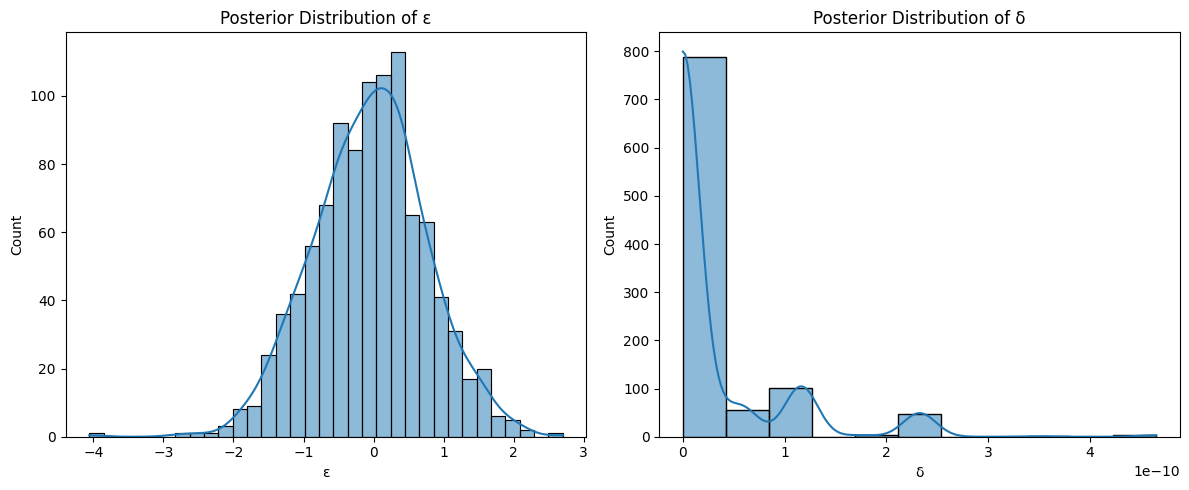


=== Strong Privacy Setting ===
Attack model accuracy: 0.5054, AUC: 0.5173

Training target model with DP...
Epoch 1, Loss: 0.7022
Epoch 2, Loss: 0.7121
Epoch 3, Loss: 0.6713
Epoch 4, Loss: 0.7089
Epoch 5, Loss: 0.6794

Performing membership inference attack...
True Positive Rate (TPR): 0.5028
False Positive Rate (FPR): 0.4932

Running Bayesian privacy estimation...


Sample: 100%|██████████| 1200/1200 [00:19, 60.67it/s, step size=7.83e-01, acc. prob=0.927]


Estimated ε: 0.0192 ± 0.0288
Estimated δ: 0.0000 ± 0.0000


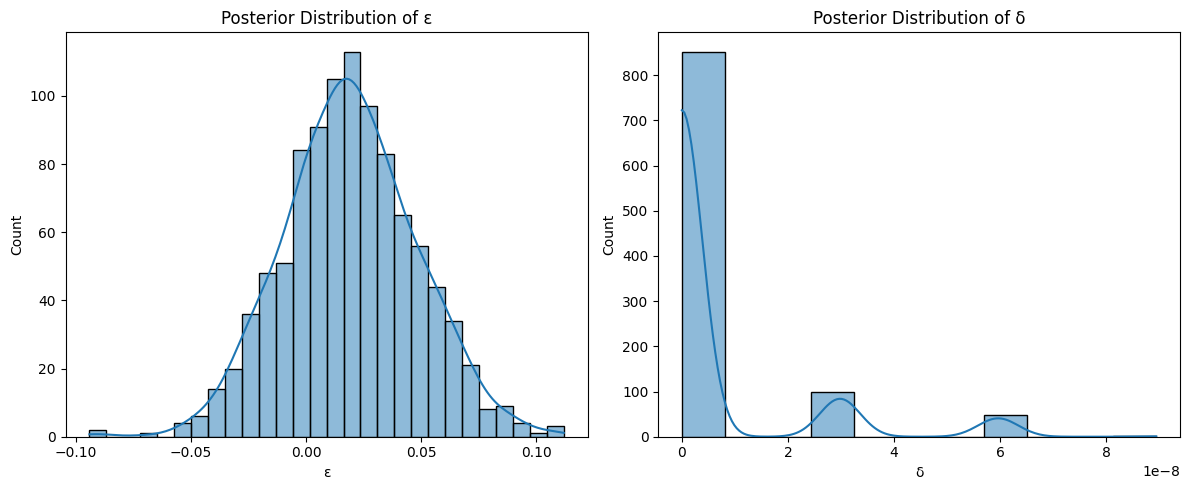


=== Weak Privacy Setting ===
Attack model accuracy: 0.5163, AUC: 0.5144

Training target model with DP...
Epoch 1, Loss: 0.6691
Epoch 2, Loss: 0.6843
Epoch 3, Loss: 0.6830
Epoch 4, Loss: 0.6639
Epoch 5, Loss: 0.6993

Performing membership inference attack...
True Positive Rate (TPR): 0.0000
False Positive Rate (FPR): 0.0000

Running Bayesian privacy estimation...


Sample: 100%|██████████| 1200/1200 [00:21, 54.91it/s, step size=6.78e-01, acc. prob=0.939]


Estimated ε: -0.0115 ± 0.8109
Estimated δ: 0.0000 ± 0.0000


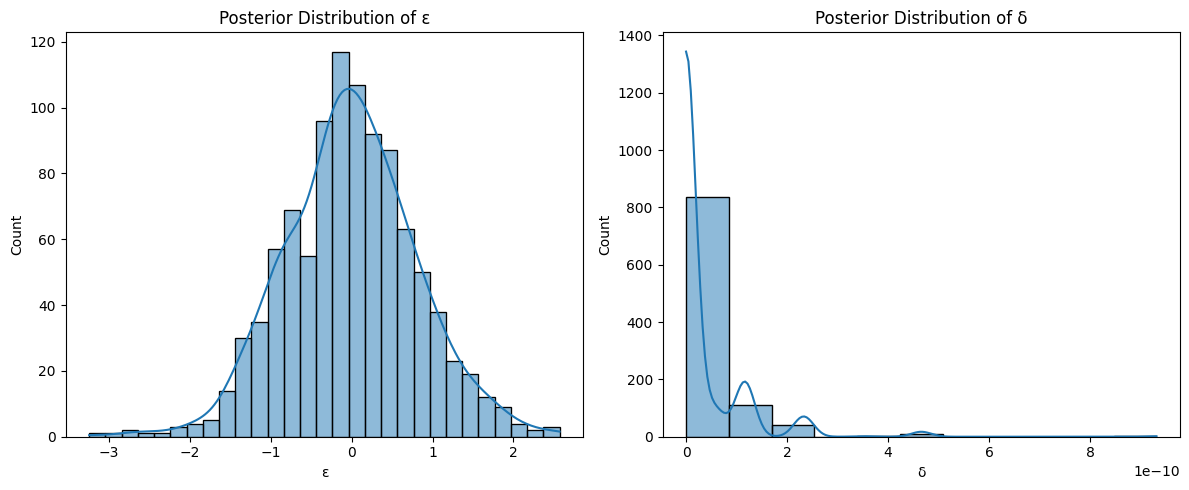

In [30]:
# Run with moderate privacy (medium noise)
print("=== Moderate Privacy Setting ===")
moderate_dp = {'sigma': 1.0, 'max_grad_norm': 1.0}
moderate_results = run_full_pipeline(X, y, dp_params=moderate_dp)

# Run with strong privacy (high noise)
print("\n=== Strong Privacy Setting ===")
strong_dp = {'sigma': 2.0, 'max_grad_norm': 1.0}
strong_results = run_full_pipeline(X, y, dp_params=strong_dp)

# Run with weak privacy (low noise)
print("\n=== Weak Privacy Setting ===")
weak_dp = {'sigma': 0.5, 'max_grad_norm': 1.0}
weak_results = run_full_pipeline(X, y, dp_params=weak_dp)

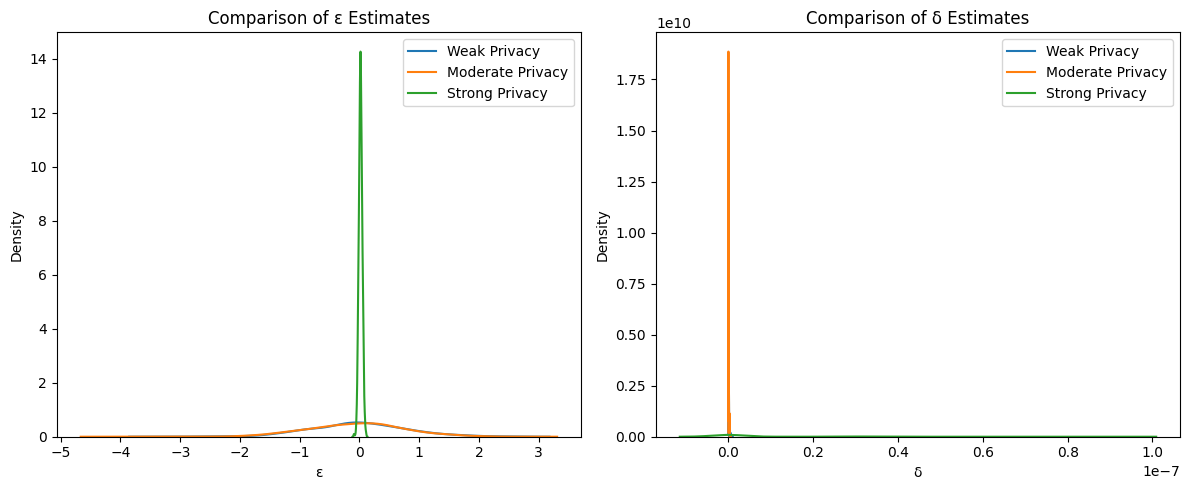

In [31]:
def compare_results(results_list, labels):
    """Compare results across different DP settings"""
    plt.figure(figsize=(12, 5))

    # Plot epsilon distributions
    plt.subplot(1, 2, 1)
    for res, label in zip(results_list, labels):
        sns.kdeplot(res['epsilon_samples'], label=label)
    plt.title('Comparison of ε Estimates')
    plt.xlabel('ε')
    plt.legend()

    # Plot delta distributions
    plt.subplot(1, 2, 2)
    for res, label in zip(results_list, labels):
        sns.kdeplot(res['delta_samples'], label=label)
    plt.title('Comparison of δ Estimates')
    plt.xlabel('δ')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Compare all results
compare_results([weak_results, moderate_results, strong_results],
                ['Weak Privacy', 'Moderate Privacy', 'Strong Privacy'])